In [1]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: Sequence to Squence - Translation
# Author: Tracy Tao
# Date: 2022/04/13
'''
建一个基于LSTM的Seq2Seq模型，使用编码器-解码器架构进行机器翻译
源语言(SRC - Input)是德语，目标语言(TRG - Output)是英语
“序列开始”<sos>和“序列结束”<eos>
'''
# 系统操作
import unicodedata
import string
import re
import random 
from io import open

# pyrotch框架
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as DataSet

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

use_cuda = torch.cuda.is_available()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if use_cuda else 'cpu')


In [2]:
# 定义标识符 <bos> <eos>
sos_token = 0
eos_token = 1

# read corpus
fra_path = 'E:\\dasein_py\\Data Analysis\\Deep Learning - Pytorch\\Deep Learning - Pytorch\\机器翻译的神经网络实现\\data\\fra.txt'
eng_path = 'E:\\dasein_py\\Data Analysis\\Deep Learning - Pytorch\\Deep Learning - Pytorch\\机器翻译的神经网络实现\\data\\eng.txt'
lines = open(fra_path, encoding = 'utf-8')
french = lines.read().strip().split('\n') # 去空格，按行切分
lines = open(eng_path, encoding = 'utf-8')
english = lines.read().strip().split('\n')

In [3]:
len(english),len(french)

(135842, 135842)

In [4]:
class Language:
    '''定义语言类：建词典、编码、单词到索引、索引到单词、设置标识符'''
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'} # 标识符索引
        self.n_words = 2 # count sos & eos
        
    def add_sentence(self, sentence):
        '''在语言中添加新句子，然后切分获得单词'''
        for word in sentence.split(' '): # tokenize sentence
            self.add_word(word)
    
    def add_word(self, word):
        '''添加单词，并且更新字典中的词频；并且建立反向索引'''
        if self.word2index.get(word,0) == 0: # if word not in self.word2index
            self.word2index[word] = self.n_words # 索引
            self.word2count[word] = 1 # 计数
            self.index2word[self.n_words] = word # 反向索引，给单词按顺序编号
            self.n_words +=1 # 记录单词数
        else:
            self.word2count[word] += 1 # 如果存在直接计数        
            

In [5]:
def UnicodeToAscii(string):
    '''
    Unicode -> Ascii 
    NFD表示字符应该分解为多个组合字符表示
    '''
    return ''.join(ch for ch in unicodedata.normalize('NFD',string) if unicodedata.category(ch) != 'Mn') # 文本标准化

def LowerEngString(string):
    '''
    function: Eng.lower()
    usage: re.sub(pattern, repl, string, count=0, flags=0)
    '''
    s = UnicodeToAscii(string.lower().strip())   # Unicode -> Ascii 
    s = re.sub(r"([.!?])", r" \1", s) # 去除标点符号
    return s


MAX_LENGTH = 5 # 设置句子的最大长度
def FilterPair(pair):
    '''
    function: 对输入单词对过滤，限制每句话的单词数
    '''
    return len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH

In [6]:
def IndexesFromSentence(class_, sentence):
    '''
    function: 输入句子，按空格分词之后对单词索引
    return：单词索引序列
    '''
    return [class_.word2index[word] for word in sentence.split(' ')]

def IndexFromSentence(class_, sentence):
    '''
    function: 输入句子，按空格分词之后对单词索引
    return: 输出的序列==MAX_LENGTH
    '''
    idx = IndexesFromSentence(class_, sentence)  # 单词索引序列
    idx.append(eos_token) # 在结尾增添eos索引
    for i in range(MAX_LENGTH - len(idx)):
         idx.append(eos_token) # 不知所云
    return idx

def IndexFromPair(pair):
    '''从一个词对到下标, return: 下标对'''
    input_variable = IndexFromSentence(input_lang, pair[0])
    target_variable = IndexFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

def SentenceFromList(class_, lst):
    '''单词列表 -> 句子'''
    result = [class_.index2word[i] for i in lst if i != eos_token]
    return ' '.join(result)

In [7]:
def metrics_acc(pred, labels):
    '''
    :params pred: predictions
    :params labels: y_true
    function: 计算正确率
    return: （正确数, 总计）
    '''
    pred = torch.max(pred.data, 1)[1] #  对于任意一行（一个样本）的输出值的第1个维度，将最大的作为预测结果
    acc = pred.eq(labels.data).sum() # pred与labels比较，并累计得到正确数
    return acc, len(labels)

In [8]:
#语料标准化处理，将每一行进行zip
pairs = [[LowerEngString(fra), LowerEngString(eng)] for fra, eng in zip(french, english)]

In [9]:
pairs[:5]

[['va  !', 'go .'],
 ['cours\u202f !', 'run !'],
 ['courez\u202f !', 'run !'],
 ['ca alors\u202f !', 'wow !'],
 ['au feu  !', 'fire !']]

In [10]:
input_lang = Language('French')
output_lang = Language('English')
pairs = [pair for pair in pairs if FilterPair(pair)]
print('有效句子对：', len(pairs))

有效句子对： 7129


In [11]:
# 建立两个词典（法文和英文的）
for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
print("总单词数:\n{}: {}\n{}: {}".format(input_lang.name, input_lang.n_words, output_lang.name, output_lang.n_words))


总单词数:
French: 4202
English: 2278


In [12]:
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]  # 打乱所有训练集句子的顺序
pairs = [IndexFromPair(pair) for pair in pairs] # 语言转变为单词的编码构成的序列

In [13]:
pairs[:5]

[([119, 208, 4104, 14, 1], [104, 765, 2195, 3, 1]),
 ([20, 226, 530, 14, 1], [65, 82, 93, 3, 1]),
 ([7, 2201, 14, 1, 1], [190, 1107, 50, 3, 1]),
 ([2405, 547, 3929, 14, 1], [544, 475, 2074, 3, 1]),
 ([20, 44, 666, 14, 1], [12, 173, 224, 3, 1])]

In [14]:
valid_size = len(pairs) // 10
if valid_size > 10000:
    valid_size = 10000
valid_size # validation set size

712

In [15]:
pp = pairs
pairs = pairs[ : - valid_size] # 训练集
valid_pairs = pp[-valid_size : -valid_size // 2] # 验证集集
test_pairs = pp[- valid_size // 2 :] # 测试集
print('训练记录：', len(pairs))
print('校验记录：', len(valid_pairs))
print('测试记录：', len(test_pairs))

训练记录： 6417
校验记录： 356
测试记录： 356


In [16]:
batch_size = 32

In [17]:
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
pairs_X[:5], pairs_Y[:5]

([[119, 208, 4104, 14, 1],
  [20, 226, 530, 14, 1],
  [7, 2201, 14, 1, 1],
  [2405, 547, 3929, 14, 1],
  [20, 44, 666, 14, 1]],
 [[104, 765, 2195, 3, 1],
  [65, 82, 93, 3, 1],
  [190, 1107, 50, 3, 1],
  [544, 475, 2074, 3, 1],
  [12, 173, 224, 3, 1]])

In [18]:
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
valid_X[:5], valid_X[:5]

([[401, 344, 2457, 14, 1],
  [2393, 128, 7, 14, 1],
  [174, 2784, 14, 1, 1],
  [57, 802, 1660, 14, 1],
  [342, 934, 3744, 14, 1]],
 [[401, 344, 2457, 14, 1],
  [2393, 128, 7, 14, 1],
  [174, 2784, 14, 1, 1],
  [57, 802, 1660, 14, 1],
  [342, 934, 3744, 14, 1]])

In [19]:
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]
test_X[:5], test_Y[:5]

([[119, 208, 484, 14, 1],
  [23, 1975, 843, 14, 1],
  [268, 208, 3032, 14, 1],
  [2566, 2567, 3, 4, 1],
  [268, 208, 1011, 14, 1]],
 [[60, 192, 1188, 3, 1],
  [12, 408, 427, 3, 1],
  [146, 192, 1187, 3, 1],
  [71, 194, 1295, 3, 1],
  [146, 192, 489, 3, 1]])

In [20]:
# 利用PyTorch的dataset和dataloader，将数据加载到加载器里面，并且分批
# 形成训练集, torch.LongTensor是64位整型
train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y)) 
train_dataset[:5]

(tensor([[ 119,  208, 4104,   14,    1],
         [  20,  226,  530,   14,    1],
         [   7, 2201,   14,    1,    1],
         [2405,  547, 3929,   14,    1],
         [  20,   44,  666,   14,    1]]),
 tensor([[ 104,  765, 2195,    3,    1],
         [  65,   82,   93,    3,    1],
         [ 190, 1107,   50,    3,    1],
         [ 544,  475, 2074,    3,    1],
         [  12,  173,  224,    3,    1]]))

In [21]:
# 形成数据加载器, 打乱顺序
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
train_loader

In [22]:
# 验证集
valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)
valid_loader

In [23]:
# 测试集
test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)
test_loader

In [24]:
# Encoder -> Decoder
# Encoder: bi-GRU: bidirectional = True 
# 在编码器中，输入层为一个嵌入（embedding）层，它将每个输入的法文词的 one-hot 编码转化为一个词向量。
# RNN对句子的词语进行循环编码
# 编码器没有输出层，将 RNN全部隐含单元的输出状态作为解码器输入
class EncoderRNN(nn.Module):
    '''Encoder - bi-GRU'''
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(EncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True,
                          num_layers = self.num_layers, bidirectional = True)
        # batch_first, 将batch_size放在第一维
    
    def forward(self, input, hidden):
        '''
        function: feed_forword
        :param input: (batch_size, length_seq)
        :param hidden: (num_layers * directions, batch_size, hidden_size)
        elem: output：(batch_size, length_seq, hidden_size)
        return: output, hidden
        '''
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def initHidden(self, batch_size):
        '''
        function: 隐含单元初始化
        return result: (num_layers * num_directions, batch, hidden_size)
        '''
        result = Variable(torch.zeros(self.num_layers * 2, batch_size, self.hidden_size))
        return result.cuda() if use_cuda else result

In [25]:
# Decoder
# 解码器需要设计损失函数\反向传播算法
# 一个嵌入（embedding）层用于将输入的 one-hot 向量转化为词向量，与编码器架构相同的循环神经网络（RNN或LSTM）
# softmax 运算来确定所对应的目标语言单词，和计算模型的损失（Loss）以完成反向传播的过程
class DecoderRNN(nn.Module):
    '''Decoder - bi-GRU'''
    def __init__(self, hidden_siz, output_size, num_layers =1):
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True,
                        num_layers = self.num_layers, bidirectional = True)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_size * 2, output_size) # 全链接层
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input) 
        # input：(batch_size, length_seq)
        # embedded: (batch_size, length_seq, hidden_size)
        output = F.relu(embedded)  # 平滑处理
        output, hidden = self.gru(output, hidden)
        output = self.dropout(output)  
        # output：(batch_size, length_seq, hidden_size * directions)
        # hidden：(n_layers * directions, batch_size, hidden_size)
        output = self.softmax(self.out(output[:, -1, :]))
        # (batch_size * output_size)
        return output, hidden
    
    def initHidden(self):
        '''
        function: 隐含单元初始化
        return result: (num_layers * num_directions, batch, hidden_size)
        '''
        result = Variable(torch.zeros(self.num_layers * 2, batch_size, self.hidden_size))
        return result.cuda() if use_cuda else result

In [26]:
hidden_size = 32
max_length = MAX_LENGTH
n_layers = 1
encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers = n_layers)
decoder = DecoderRNN(hidden_size, output_lang.n_words, num_layers = n_layers)
encoder, decoder

(EncoderRNN(
   (embedding): Embedding(4202, 32)
   (gru): GRU(32, 32, batch_first=True, bidirectional=True)
 ),
 DecoderRNN(
   (embedding): Embedding(2278, 32)
   (gru): GRU(32, 32, batch_first=True, bidirectional=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (out): Linear(in_features=64, out_features=2278, bias=True)
   (softmax): LogSoftmax(dim=1)
 ))

In [27]:
if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

In [28]:
learning_rate = 0.0001
# 为两个网络分别定义优化器
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

In [29]:
# 定义损失函数 CrossEntropyLoss()=log_softmax() + NLLLoss() 
criterion = nn.NLLLoss()
# 有 50% 的概率选用这种直接使用正确答案的监督学习方式
teacher_forcing_ratio = 0.5 

In [30]:
# 用于记录训练中的损失信息，后面绘制图像用
plot_losses = []
print_loss_total = 0
print_loss_avg = 0

In [39]:
def train():
    global plot_losses
    global print_loss_total
    global print_loss_avg
    print_loss_total = 0
    
    for data in train_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable: (batch_size, length_seq)
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable: (batch_size, length_seq)
        
        encoder_hidden = encoder.initHidden(data[0].size()[0]) # 初始化编码器状态
        
        encoder_optimizer.zero_grad() # 清空梯度
        decoder_optimizer.zero_grad() # 清空梯度
        
        loss = 0
        
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs: (batch_size, length_seq, hidden_size*direction)
        # encoder_hidden: (direction*n_layer, batch_size, hidden_size)
        
        decoder_input = Variable(torch.LongTensor([[sos_token]] * target_variable.size()[0]))
        # decoder_input: (batch_size, length_seq)
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        # decoder_input: (batch_size, length_seq)
        
        decoder_hidden = encoder_hidden # 继承encoder隐藏单元
        # decoder_hidden: (direction*n_layer, batch_size, hidden_size)
        
        # teacher_forcing_ratio： 用target中的翻译结果作为监督信息 - 50%
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        base = torch.zeros(target_variable.size()[0]) 
        
        if use_teacher_forcing: # 如果使用教师监督: 将下一个时间步的监督信息输入给解码器
            for di in range(MAX_LENGTH):  # 对时间步循环
                
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # decoder_ouput：(batch_size, output_size)
                
                loss += criterion(decoder_output, target_variable[:, di]) # 累计损失
                
                decoder_input = target_variable[:, di].unsqueeze(1) # 将训练数据当做下一时间步的输入
                # decoder_input: (batch_size, length_seq)
                
        else: # 反之，使用解码器自己的预测作为下一时间步的输入
            for di in range(MAX_LENGTH): # 对时间步循环
                
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                #decoder_ouput：(batch_size, output_size(input_size))
                
                topv, topi = decoder_output.data.topk(1, dim = 1) # 从输出结果中选择出一个数值最大的单词作为输出
                # topi：(batch_size, k)
                ni = topi[:, 0]
                decoder_input = Variable(ni.unsqueeze(1)) 
                # decoder_input: (batch_size, length_seq)
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input
                
                loss += criterion(decoder_output, target_variable[:, di])  # 累计损失
        
        loss.backward() # 反向传播
        
        loss = loss.cpu() if use_cuda else loss
        
        encoder_optimizer.step() # 梯度下降
        decoder_optimizer.step() # 梯度下降
        # print(loss.data.numpy())
        print_loss_total += loss.data.numpy() # 累加总误差
        
    print_loss_avg = print_loss_total / len(train_loader)  # 平均误差

In [32]:
valid_loss = 0
rights = []

In [40]:
def evaluation():
    global valid_loss
    global rights
    valid_loss = 0
    rights = []
    
    for data in valid_loader: # 验证集
        
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable: (batch_size, length_seq)
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable: (batch_size, length_seq)
        
        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs: (batch_size, length_seq, hidden_size*direction)
        # encoder_hidden: (direction*n_layer, batch_size, hidden_size)
        
        decoder_input = Variable(torch.LongTensor([[sos_token]] * target_variable.size()[0]))
        # decoder_input: (batch_size, length_seq)
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        # decoder_input: (batch_size, length_seq)
        
        decoder_hidden = encoder_hidden # 继承encoder隐藏单元
        # decoder_hidden: (direction*n_layer, batch_size, hidden_size)
        
        # teacher_forcing_ratio： 用target中的翻译结果作为监督信息 - 50%
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        # 没有教师监督使用解码器自己的预测作为下一时间步的输入
        for di in range(MAX_LENGTH): # 对时间步循环

            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            #decoder_ouput：(batch_size, output_size(input_size))

            topv, topi = decoder_output.data.topk(1, dim = 1) # 从输出结果中选择出一个数值最大的单词作为输出
            # topi：(batch_size, k)
            ni = topi[:, 0]
            decoder_input = Variable(ni.unsqueeze(1)) 
            # decoder_input: (batch_size, length_seq)
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            right = metrics_acc(decoder_output, target_variable[:, di]) 
            # right: (猜对个数，总数)
            rights.append(right)
            
            loss += criterion(decoder_output, target_variable[:, di]) # 损失函数
            
        loss = loss.cpu() if use_cuda else loss
        # print(loss)
        valid_loss += loss.data.numpy()

In [42]:
plot_losses = []
num_epoch = 10
for epoch in range(num_epoch):
    train()
    evaluation()
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print(f'进程:{epoch}, 训练损失:{print_loss_avg:.4f}, 校验损失:{valid_loss/len(valid_loader):.4f}, 词正确率:{100.0 * right_ratio:.2f}%')
    plot_losses.append([print_loss_avg, valid_loss / len(valid_loader), right_ratio])
                                                  

进程:0, 训练损失:11.3943, 校验损失:13.8531, 词正确率:56.63%
进程:1, 训练损失:11.3721, 校验损失:13.8565, 词正确率:57.58%
进程:2, 训练损失:11.2954, 校验损失:13.5022, 词正确率:57.58%
进程:3, 训练损失:11.2117, 校验损失:13.5722, 词正确率:57.13%
进程:4, 训练损失:11.1538, 校验损失:13.6409, 词正确率:56.52%
进程:5, 训练损失:11.1451, 校验损失:14.2387, 词正确率:57.42%
进程:6, 训练损失:11.0819, 校验损失:13.8633, 词正确率:57.81%
进程:7, 训练损失:11.0461, 校验损失:14.0995, 词正确率:57.25%
进程:8, 训练损失:11.0188, 校验损失:14.2541, 词正确率:57.58%
进程:9, 训练损失:10.9420, 校验损失:13.5143, 词正确率:57.75%


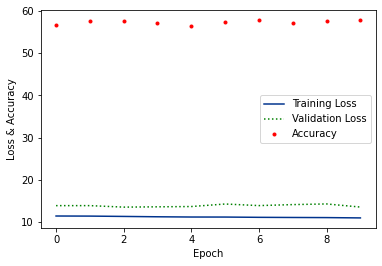

In [43]:
# 将统计指标绘图
a = [i[0] for i in plot_losses]
b = [i[1] for i in plot_losses]
c = [i[2] * 100 for i in plot_losses]
plt.plot(a, '-', label = 'Training Loss',color = '#00338D')
plt.plot(b, ':', label = 'Validation Loss', color = 'green')
plt.plot(c, '.', label = 'Accuracy', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend(loc='best')


In [44]:
# 加载训练过的神经网络模型
encoder_ = torch.load('E:\\dasein_py\\Data Analysis\\Deep Learning - Pytorch\\Deep Learning - Pytorch\\机器翻译的神经网络实现\\data\\Encoder_normal_cpu.mdl')
decoder_ = torch.load('E:\\dasein_py\\Data Analysis\\Deep Learning - Pytorch\\Deep Learning - Pytorch\\机器翻译的神经网络实现\\data\\Decoder_normal_cpu.mdl')
if use_cuda:
    encoder_ = encoder_.cuda()
    decoder_ = decoder_.cuda()

D:\anaconda3\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\anaconda3\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.GRU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\anaconda3\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = 

In [45]:
# 首先，在测试集中随机选择20个句子作为测试
indices = np.random.choice(range(len(test_X)), 20)

In [52]:
for item in indices: # 对每个句子进行循环
    data = [test_X[item]]
    target = [test_Y[item]]
    print(SentenceFromList(input_lang, data[0])) # 原句
    input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
    # input_variable：(batch_size, length_seq)
    target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
    # target_variable: (batch_size, length_seq)
    # 初始化编码器
    encoder_hidden = encoder.initHidden(input_variable.size()[0])

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden) # 编码器开始编码，结果存储到了encoder_hidden中
    # encoder_outputs：(batch_size, length_seq, hidden_size*direction)
    # encoder_hidden：(direction*n_layer, batch_size, hidden_size)

    decoder_input = Variable(torch.LongTensor([[sos_token]] * target_variable.size()[0])) # 将sos作为解码器的第一个输入
    # decoder_input：(batch_size, length_seq)
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden  # 将编码器的隐含层单元数值拷贝给解码器的隐含层单元
    # decoder_hidden：(direction*n_layer, batch_size, hidden_size)

    # 没有教师指导下的预测: 使用解码器自己的预测作为解码器下一时刻的输入
    output_sentence = []
    decoder_attentions = torch.zeros(max_length, max_length)
    rights = []
   
    for di in range(MAX_LENGTH):  # 按照输出字符进行时间步循环

        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden) # 解码器一个时间步的计算
        #decoder_ouput：(batch_size, output_size(input_size))

        topv, topi = decoder_output.data.topk(1, dim = 1) # 解码器的输出: 选择第一轴最大项
        #topi：（batch_size, k）
        ni = topi[:, 0]
        decoder_input = Variable(ni.unsqueeze(1))
        ni = ni.numpy()[0]

        output_sentence.append(ni) # 将本时间步输出的单词编码加到output_sentence里面
        # decoder_input：(batch_size, length_seq)
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        right = metrics_acc(decoder_output, target_variable[:, di])  # 计算输出字符的准确度
        rights.append(right)
        
    sentence = SentenceFromList(output_lang, output_sentence) # result

    standard = SentenceFromList(output_lang, target[0]) # label


    print('机器翻译：', sentence)
    print('标准翻译：', standard)
  
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('词准确率：', 100.0 * right_ratio)
    print('')
    

c'est pratiquement impossible .
机器翻译： it's is . .
标准翻译： it's nearly impossible .
词准确率： 60.0

je suis faineant .
机器翻译： i'm am .
标准翻译： i'm lazy .
词准确率： 80.0

arrete de geindre .
机器翻译： they it .
标准翻译： stop whimpering .
词准确率： 60.0

vous l'avez fait  !
机器翻译： you me .
标准翻译： you've done it !
词准确率： 20.0

elles sont medecins .
机器翻译： they are .
标准翻译： they're doctors .
词准确率： 60.0

je suis interessee .
机器翻译： i'm am .
标准翻译： i'm interested .
词准确率： 80.0

c'est une coincidence .
机器翻译： it's a . .
标准翻译： that's a coincidence .
词准确率： 60.0

ils m'ont enleve .
机器翻译： they is . .
标准翻译： they kidnapped me .
词准确率： 60.0

j'etais preoccupee .
机器翻译： i was it .
标准翻译： i was concerned .
词准确率： 80.0

vous etes inoubliables .
机器翻译： you're are .
标准翻译： you're unforgettable .
词准确率： 80.0

je l'ai cause .
机器翻译： i like you .
标准翻译： i caused this .
词准确率： 60.0

elle lui pardonna .
机器翻译： she she him .
标准翻译： she forgave him .
词准确率： 80.0

elles sont vieilles .
机器翻译： they're all .
标准翻译： they're old .
词准确率： 80.0

tom semble perdu .
机器

In [97]:
# ATTENTION mechanism
MAX_LENGTH = 10
batch_size = 32

#对英文做标准化处理
pairs = [[LowerEngString(fra), LowerEngString(eng)] for fra, eng in zip(french, english)]

# 对句子对做过滤，处理掉那些超过MAX_LENGTH长度的句子
input_lang = Language('French')
output_lang = Language('English')
pairs = [pair for pair in pairs if FilterPair(pair)]
print('有效句子对：', len(pairs))

# 建立两个字典（中文的和英文的）
for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
print("总单词数:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


# 形成训练集，首先，打乱所有句子的顺序
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]

# 将语言转变为单词的编码构成的序列
pairs = [IndexFromPair(pair) for pair in pairs]

# 形成训练集、校验集和测试集
valid_size = len(pairs) // 10
if valid_size > 10000:
    valid_size = 10000

valid_pairs = pairs[-valid_size : -valid_size // 2]
test_pairs = pairs[- valid_size // 2 :]
pairs = pairs[ : - valid_size]

# 利用PyTorch的dataset和dataloader对象，将数据加载到加载器里面，并且自动分批

batch_size = 32 #一撮包含30个数据记录，这个数字越大，系统在训练的时候，每一个周期处理的数据就越多，这样处理越快，但总的数据量会减少

print('训练记录：', len(pairs))
print('校验记录：', len(valid_pairs))
print('测试记录：', len(test_pairs))

# 形成训练对列表，用于喂给train_dataset
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]


# 形成训练集
train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y))
# 形成数据加载器
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)


# 校验数据
valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# 测试数据
test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)

有效句子对： 104674
总单词数:
French 25316
English 12274
训练记录： 94674
校验记录： 5000
测试记录： 5000


In [133]:
class AttnDecoderRNN(nn.Module):
    '''加入注意力机制的解码器'''
    def __init__(self, hidden_size, output_size, n_layers = 1, dropout=0.1, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        # 注意力网9络
        self.attn = nn.Linear(self.hidden_size * (2*n_layers + 1), self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout)
        
        # bi-rnn
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional = True,num_layers = self.n_layers, batch_first = True)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)
    
    def forward(self, input, hidden, encoder_outputs):
        # batch_first
        # input: (batch_size, length_seq)
        embedded = self.embedding(input)
        # embedded: (batch_size, length_seq, hidden_size)
        embedded = embedded[:, 0, :]
        # embedded: (batch_size, 1, hidden_size)
        embedded = self.dropout(embedded)
        
        # hidden: (direction*n_layer, batch_size, hidden_size)
        temp_for_transpose = torch.transpose(hidden, 0, 1).contiguous()
        # torch.contiguous()方法首先拷贝了一份张量在内存中的地址，然后将地址按照形状改变后的张量的语义进行排列。
        
        # temp_for_transpose: (batch_size, direction*n_layer, hidden_size)
        temp_for_transpose = temp_for_transpose.view(temp_for_transpose.size()[0], -1)
        
        # touch.view()方法对张量改变“形状”其实并没有改变张量在内存中真正的形状
        hidden_attn = temp_for_transpose
        
        # hidden_attn: (batch_size, direction*n_layers*hidden_size)
        input_to_attention = torch.cat((embedded, hidden_attn), 1)
        
        # input_to_attention: (batch_size, hidden_size * (1 + direction * n_layers))
        attn_weights = F.softmax(self.attn(input_to_attention),dim=1)
        # attn_weights：(batch_size, self.max_length)
        attn_weights = attn_weights[:, : encoder_outputs.size()[1]] # 当输入数据不标准的时候，对weights截取必要的一段
        # attn_weights: (batch_size ,len(encoder_outputs[0])
        attn_weights = attn_weights.unsqueeze(1)
        # attn_weights: (batch_size , 1, len(encoder_outputs[0])
        
        # encoder_output：(batch_size, len(encoder_outputs[0]), hidden_size*direction)
        attn_applied = torch.bmm(attn_weights, encoder_outputs) 
        # batch matrix multiply 忽略第一个batch纬度
        # attn_applied：(batch_size, 1, hidden_size*direction)
        
        output = torch.cat((embedded, attn_applied[:,0,:]), 1)
        # output: (batch_size, hidden_size*(direction+1))
        
        output = self.attn_combine(output).unsqueeze(1)
        # output：(batch_size, len(encoder_outputs[0], hidden_size)
        
        output = F.relu(output)
        output = self.dropout(output)
        output, hidden = self.gru(output, hidden)
        # output：(batch_size, length_seq, hidden_size * directions)
        # hidden：(n_layers * directions, batch_size, hidden_size)
        output = self.out(output[:, -1, :]) 
        # output：(batch_size * output_size)
        output = F.log_softmax(output, dim = 1) # FC
        # output：(batch_size * output_size)
        return output, hidden, attn_weights
    
    def initHidden(self, batch_size):
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        return result.cuda() if use_cuda else result

In [123]:
# 重新定义解码器架构即可，其他变量不变
hidden_size = 32
max_length = MAX_LENGTH
n_layers = 1
encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers = n_layers)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout=0.5,max_length = max_length, n_layers = n_layers)